This script creates a csv which holds the corresponding validation data points from both Chesapeake Bay Program's (CBP) Water Quality dataset and the two satellite datasets. The csv contains one row for each day and pixel in which there was a CBP validation point, and either a MUR or a Geopolar satellite pixel.

Before running this script, be sure to run:
1. (`01_download_CPBWaterQuality_data.py`) download CBP Water Quality dataset
2. (`.py`) download/access Geopolar
3. (`.py`) download/access MUR

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
import geopandas as gpd

In [3]:
pd.set_option('display.max_rows', 100)

In [4]:
# cols = ['EventId', 'SampleDate', 'SampleTime', 
#         'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
# wq2 = pd.read_csv('./data/WaterQualityWaterQualityStation.csv', usecols=cols)  # , skipfooter=1)
# # wq = wq.drop([521779])  # Remove the empty bottom row
# wq2['SampleDate'] = pd.to_datetime(wq2['SampleDate'], format='%m/%d/%Y')

In [5]:
cols = ['EventId', 'Station', 'SampleDate', 'SampleTime', 'Unit',
        'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
wq = pd.read_csv('./data/raw/WaterQuality_ChesapeakeBayProgram.csv', usecols=cols)  # , skipfooter=1)
# wq = wq.drop([521779])  # Remove the empty bottom row
wq['SampleDate'] = pd.to_datetime(wq['SampleDate'], format='%m/%d/%Y')
# # Remove rows before the beginning of the geopolar collection period
# wq = wq[wq['SampleDate'] >= '2002-09-01']
# wq = wq[wq['SampleDate'] <= '2022-03-20']
# # Remove rows that have a null SST value
wq = wq[~wq['MeasureValue'].isnull()]
wq = wq.sort_values('SampleDate').reset_index(drop=True)

In [6]:
wq

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
0,67626.0,WQN0273,2003-01-02,15:00:00,0.0,I,6.500,DEG C,39.94649,-76.36774
1,67628.0,WQN0201,2003-01-02,16:00:00,0.0,I,6.000,DEG C,40.05454,-76.53080
2,67625.0,WQN0301,2003-01-02,12:55:00,0.0,I,3.000,DEG C,40.95814,-76.61912
3,67629.0,WQN0401,2003-01-02,17:20:00,0.0,I,3.100,DEG C,40.96814,-76.87330
4,67627.0,WQN0305,2003-01-02,15:10:00,0.0,I,1.700,DEG C,41.76535,-76.44050
...,...,...,...,...,...,...,...,...,...,...
565719,608299.0,CB6.3,2022-06-30,14:43:00,9.0,M,23.382,DEG C,37.41153,-76.15966
565720,608296.0,CB6.2,2022-06-30,09:17:00,2.0,M,24.571,DEG C,37.48680,-76.15633
565721,608296.0,CB6.2,2022-06-30,09:17:00,7.0,BP,23.095,DEG C,37.48680,-76.15633
565722,608284.0,CB5.4,2022-06-30,11:59:00,18.0,M,23.548,DEG C,37.80013,-76.17466


### Quality Checks

In [7]:
# Make sure all values have unit of Celcius
assert len(np.unique(wq.Unit)) == 1
assert np.unique(wq.Unit) == ['DEG C']

In [8]:
wq = wq[wq.MeasureValue < 100]

In [9]:
assert len(wq[wq.MeasureValue > 100]) == 0

**Layer Codes**
from page 33 of [the database schema](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf).
| Code | Meaning|
| :--: | :--: |
| AB | FIXED ABOVE BOTTOM |
| AP | ABOVE PYCNOCLINE |
| B | BOTTOM |
| BP | BELOW PYCNOCLINE |
| BS | FLOATING BELOW SURFACE |
| I | INTEGRATED |
| M | MID-DEPTH |
| M1 | MIDDLE 1/3 OF TOTAL STATION DEPTH |
| M2 | MIDDLE 2/3 OF TOTAL STATION DEPTH |
| S | SURFACE |
| VP | VERTICAL PROFILE |

Removing top labelled points reduces about 15k rows (565k --> 550k)

Removing bottom labelled points removes another 10k (down to 540k rows)

Overall 25k drop (565k --> 540k)

In [10]:
# Remove samples taken at or just below the surface
wq = wq[(wq.Layer != 'S') & (wq.Layer != 'BS') & (wq.Layer != 'AP')]
# Remove samples taken at the bottom
wq = wq[(wq.Layer != 'B') & (wq.Layer != 'AB')]

## Filtering: Spatial

In [11]:
cbay_shape = gpd.read_file("/Users/rwegener/repos/mhw_ocetrac_census/data/SST-geopolar-chesapeake/cbay_vector.geojson")

In [12]:
cbay_shape = cbay_shape[cbay_shape.DN == 0].iloc[1]

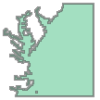

In [13]:
cbay_shape.geometry

In [14]:
wq_gpd = gpd.GeoDataFrame(
    wq, geometry=gpd.points_from_xy(wq['Longitude'], wq['Latitude']), 
    crs='epsg:4326')

Spatial filtering drops 212k rows (from 540k --> 328k , maybe 40% decrease)

Time: ~2 min

In [15]:
%%time

wq_filtered = wq_gpd[wq_gpd['geometry'].intersects(cbay_shape.geometry)]

CPU times: user 2min 1s, sys: 750 ms, total: 2min 2s
Wall time: 2min 4s


In [16]:
wq = wq_filtered.drop(columns='geometry')

<AxesSubplot: xlabel='Latitude', ylabel='Depth'>

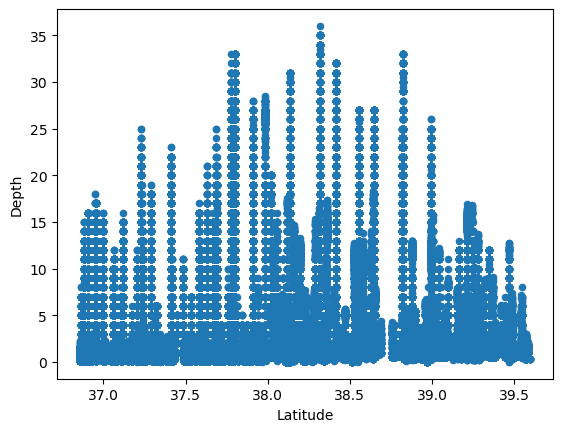

In [17]:
wq.plot.scatter('Latitude', 'Depth')

<AxesSubplot: xlabel='Latitude', ylabel='Depth'>

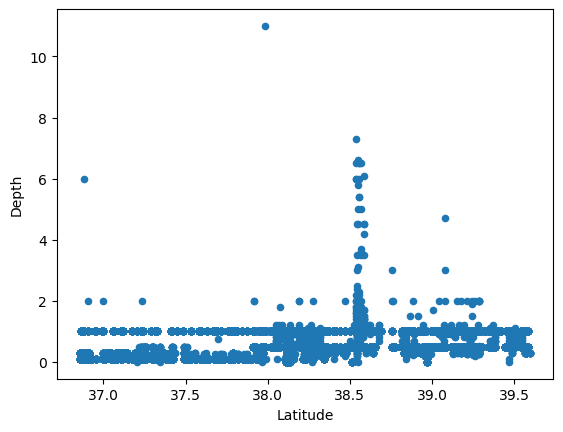

In [18]:
wq.groupby(['Station', 'SampleDate', 'SampleTime']).min('Depth').plot.scatter('Latitude', 'Depth')

### Isolating just one depth observation per location

**Question that is surprisingly hard to answer: What is the mixed layer depth in the CBay?**

In [19]:
def find_correct_depth(df):
    if len(df) > 1:
        # Get the row with the depth closest to 2 meters
        df = df.iloc[(df['Depth']-2).abs().argsort()[:1]]
    # if there was only 1 row to begin with, just return that one
    return df

This drops a lot (286k) of rows: From 328k --> 42k (1/6 or so of the original values)

In [20]:
%%time

wq_applied = wq.groupby(['Station', 'SampleDate', 'SampleTime']) \
                .apply(find_correct_depth)

CPU times: user 41.9 s, sys: 694 ms, total: 42.6 s
Wall time: 43 s


<AxesSubplot: xlabel='Latitude', ylabel='Depth'>

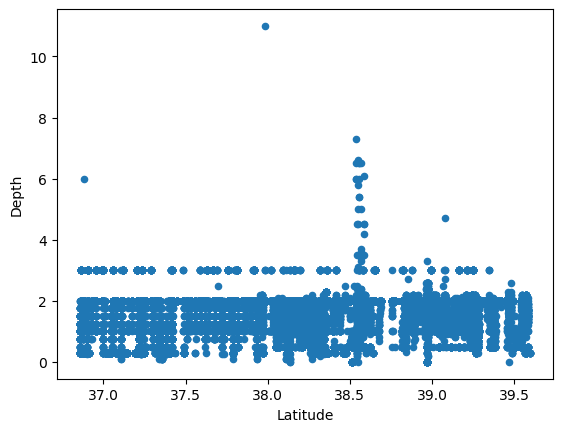

In [21]:
wq_applied.plot.scatter('Latitude', 'Depth')

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

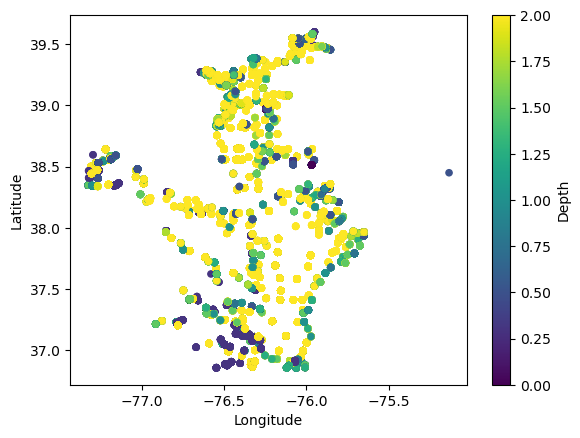

In [22]:
wq_applied.plot.scatter('Longitude', 'Latitude', c='Depth', vmax=2)

In [23]:
wq_applied

EventId      Station SampleDate  \
Station     SampleDate SampleTime                                            
1AAUA001.39 2007-03-22 10:25:00   108602   20932.0  1AAUA001.39 2007-03-22   
            2007-06-18 11:47:00   118953    7872.0  1AAUA001.39 2007-06-18   
            2007-10-29 12:10:00   135833   87078.0  1AAUA001.39 2007-10-29   
            2007-12-10 10:35:00   137964   87652.0  1AAUA001.39 2007-12-10   
            2008-02-04 10:30:00   140568   88086.0  1AAUA001.39 2008-02-04   
...                                            ...          ...        ...   
YRK028.58   2008-07-22 09:58:00   157944  118634.0    YRK028.58 2008-07-22   
            2008-08-22 10:44:00   161508  119501.0    YRK028.58 2008-08-22   
            2008-09-17 10:44:00   164688   80263.0    YRK028.58 2008-09-17   
            2008-10-16 10:32:00   167520   80995.0    YRK028.58 2008-10-16   
            2008-11-20 16:20:00   170138   81437.0    YRK028.58 2008-11-20   

                                         SampleTime  Depth Layer  \
Station     SampleDate SampleTime                                  
1AAUA001.39 2007-03-22 10:25:00   108602   10:25:00   1.50    B    
            2007-06-18 11:47:00   118953   11:47:00   1.50    B    
            2007-10-29 12:10:00   135833   12:10:00   1.50    B    
            2007-12-10 10:35:00   137964   10:35:00   1.50    M    
            2008-02-04 10:30:00   140568   10:30:00   1.50    B    
...                                             ...    ...   ...   
YRK028.58   2008-07-22 09:58:00   157944   09:58:00   1.50    VP   
            2008-08-22 10:44:00   161508   10:44:00   1.25    VP   
            2008-09-17 10:44:00   164688   10:44:00   2.00    VP   
            2008-10-16 10:32:00   167520   10:32:00   2.00    VP   
            2008-11-20 16:20:00   170138   16:20:00   2.00    VP   

                                          MeasureValue   Unit  Latitude  \
Station     SampleDate SampleTime                                         
1AAUA001.39 2007-03-22 10:25:00   108602          8.30  DEG C  38.40000   
            2007-06-18 11:47:00   118953         26.20  DEG C  38.40000   
            2007-10-29 12:10:00   135833         14.50  DEG C  38.40000   
            2007-12-10 10:35:00   137964          5.20  DEG C  38.40000   
            2008-02-04 10:30:00   140568          4.90  DEG C  38.40000   
...                                                ...    ...       ...   
YRK028.58   2008-07-22 09:58:00   157944         29.27  DEG C  37.48865   
            2008-08-22 10:44:00   161508         26.58  DEG C  37.48865   
            2008-09-17 10:44:00   164688         25.19  DEG C  37.48865   
            2008-10-16 10:32:00   167520         21.53  DEG C  37.48865   
            2008-11-20 16:20:00   170138          9.57  DEG C  37.48865   

                                          Longitude  
Station     SampleDate SampleTime                    
1AAUA001.39 2007-03-22 10:25:00   108602  -77.32000  
            2007-06-18 11:47:00   118953  -77.32000  
            2007-10-29 12:10:00   135833  -77.32000  
            2007-12-10 10:35:00   137964  -77.32000  
            2008-02-04 10:30:00   140568  -77.32000  
...                                             ...  
YRK028.58   2008-07-22 09:58:00   157944  -76.74903  
            2008-08-22 10:44:00   161508  -76.74903  
            2008-09-17 10:44:00   164688  -76.74903  
            2008-10-16 10:32:00   167520  -76.74903  
            2008-11-20 16:20:00   170138  -76.74903  

[41812 rows x 10 columns]

### Filtering: Points below a certain depth

Double check units. Pick bulk temperature. Don't count the same place more than once.

Check that moorings also measure at night. I could take the nighttime ones outspecifically. Could also look at curve to see.

Could look at the docs for L3S ACSPO data has a curve for the two daytime and nighttime overpasses and the diurnal warming pattern.

Read on "Layer" metadata column?

In [ ]:
wq[wq.Station == 'LE1.4'].sort_values(['SampleDate', 'SampleTime', 'Depth']).head(50)

In [ ]:
wq_bydate = wq.groupby(['Station', 'SampleDate']).count()['EventId']

In [ ]:
moorings_maybe = wq_bydate[wq_bydate > 23]

In [ ]:
moorings_maybe.index.unique(level='Station')

In [ ]:
wq[wq.Station == 'ARF.MS2'].sort_values(['SampleDate', 'SampleTime', 'Depth']).head(50)

### Searching for stations with obs on consecutive days

In [ ]:
# wq = wq[(wq.Depth > 0.1) & (wq.Depth < 4)]

## Rearranging the df to isolate observations

In [ ]:
# Create a sample datetime column
wq.assign(SampleDateTime = wq.SampleDate.dt.strftime('%Y-%m-%d') + ' ' + wq.SampleTime)

## Trying to look at T profiles across the bay

In [ ]:
len(np.unique(wq.EventId))

In [ ]:
wq[wq.EventId == 67626]

In [ ]:
wq.Depth.quantile(.9)

In [ ]:
wq.groupby('EventId').min()

In [ ]:
wq.plot.scatter('MeasureValue', 'Depth')

In [ ]:
wq_profiles.plot.scatter('MeasureValue', 'Depth')

In [ ]:
wq_profiles = wq[wq.Layer == 'VP']

In [ ]:
wq_profiles.sort_values(['Station', 'SampleDate'])

In [ ]:
wq_profiles[wq_profiles.EventId == 413522].plot.scatter('MeasureValue', 'Depth')

## Creating a single value for each date & location

In [ ]:
wq['Datetime'] = pd.to_datetime(wq['SampleDate'].dt.strftime('%Y-%m-%d') + ' ' + wq['SampleTime'])

# wq = wq.groupby([(wq['Datetime'].dt.date), 'Latitude', 'Longitude']).mean()

In [ ]:
wq = wq.reset_index()
wq = wq.rename(columns={'Datetime': 'SampleDate'})

In [ ]:
wq[wq.SampleTime == '02:00:00']

In [ ]:
wq_daily = wq.groupby(['Station', 'SampleDate']).mean()
wq_daily = wq_daily.sort_index()

In [ ]:
wq_daily

In [ ]:
wq_daily['Date'] = wq_daily.index.get_level_values(1)

In [ ]:
wq_daily_diff = wq_daily.diff()

In [ ]:
wq_daily_diff

In [ ]:
from datetime import timedelta

In [ ]:
wq_daily_diff[wq_daily_diff.Date == timedelta(days=1)]

In [ ]:
wq[(wq.SampleTime < '06:00')]

In [ ]:
wq[(wq.SampleTime < '04:00') | (wq.SampleTime > '22:00')] \
    .sort_values(['Station', 'SampleDate', 'SampleTime', 'Depth']).head(200)

**Conclusion: there aren't any buoys in this dataset 🫢** 

### What is the foundation depth?

In [ ]:
wq[wq.Layer == 'VP']

In [ ]:
wq[wq.Station == 'MDE.0804019'].sort_values(['SampleDate', 'SampleTime', 'Depth'])

In [ ]:
wq[(wq.Station == 'MDE.0804019') & (wq.SampleDate == '2019-03-18')].sort_values('Depth').plot \
.scatter(x='MeasureValue', y='Depth')

In [ ]:
np.unique(wq[wq.Station == 'CB4.1C'].sort_values(['SampleDate', 'SampleTime', 'Depth']).SampleDate)

A summer profile (warmer on top!)

In [ ]:
wq[(wq.Station == 'CB4.1C') & (wq.SampleDate == '2004-07-20')].sort_values('Depth').plot \
.scatter(x='MeasureValue', y='Depth')

A winter profile (warmer underneath!)

In [ ]:
wq[(wq.Station == 'CB4.1C') & (wq.SampleDate == '2003-01-14')].sort_values('Depth').plot \
.scatter(x='MeasureValue', y='Depth')

In [ ]:
wq[(wq.Station == 'CB4.1C')].sort_values('Depth').plot \
.scatter(x='MeasureValue', y='Depth')

In [ ]:
wq[wq.Depth > 7].groupby(['Station', 'SampleDate'])['MeasureValue'].mean()

In [ ]:
wq = wq[wq.Depth >=2 ].groupby(['Station', 'SampleDate', 'Latitude', 'Longitude'])['MeasureValue'].mean()

In [ ]:
wq = wq.reset_index()

In [ ]:
wq

### Open Question: Do I need some spatial filtering for the intersect operation to be reasonable?

## Back to Processing pipeline

### Intersect Operation

In [24]:
import warnings

In [25]:
def get_satellite_sst(full_sst, lat, lon, time):
    # print('lat', lat, 'lon', lon, 'time', time)
    # time does NOT have nearest interpolation because we do not want adjacent days to
    # be selected
    try:
        matching_array = full_sst.sel(lat=lat, lon=lon, 
                                      method='nearest').sel(time=time.strftime('%Y-%m-%d')).values
        if matching_array.size == 1:
            matching_sst = matching_array[0]
        else:
            matching_sst = np.nan
            warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
    except KeyError:
        # If a key error was raised corresponding date was not found. Return nan for that sample location
        matching_sst = np.nan
    # print('returning ', matching_sst)
    return matching_sst

In [26]:
wq = wq_applied

In [27]:
wq = wq[['MeasureValue', 'Latitude', 'Longitude', 'SampleDate']]
# wq = wq[['MeasureValue', 'Latitude', 'Longitude', 'Datetime']]
wq_sst = wq.copy()
wq_sst['geopolar_sst'] = -999

In [28]:
geopolar = xr.open_dataset('/Users/rwegener/repos/mhw_ocetrac_census/data/SST-geopolar-chesapeake/SST_geopolar_chesapeake.nc')
geopolar = geopolar.analysed_sst

In [29]:
wq_sst

MeasureValue  Latitude  Longitude  \
Station     SampleDate SampleTime                                             
1AAUA001.39 2007-03-22 10:25:00   108602          8.30  38.40000  -77.32000   
            2007-06-18 11:47:00   118953         26.20  38.40000  -77.32000   
            2007-10-29 12:10:00   135833         14.50  38.40000  -77.32000   
            2007-12-10 10:35:00   137964          5.20  38.40000  -77.32000   
            2008-02-04 10:30:00   140568          4.90  38.40000  -77.32000   
...                                                ...       ...        ...   
YRK028.58   2008-07-22 09:58:00   157944         29.27  37.48865  -76.74903   
            2008-08-22 10:44:00   161508         26.58  37.48865  -76.74903   
            2008-09-17 10:44:00   164688         25.19  37.48865  -76.74903   
            2008-10-16 10:32:00   167520         21.53  37.48865  -76.74903   
            2008-11-20 16:20:00   170138          9.57  37.48865  -76.74903   

                                         SampleDate  geopolar_sst  
Station     SampleDate SampleTime                                  
1AAUA001.39 2007-03-22 10:25:00   108602 2007-03-22          -999  
            2007-06-18 11:47:00   118953 2007-06-18          -999  
            2007-10-29 12:10:00   135833 2007-10-29          -999  
            2007-12-10 10:35:00   137964 2007-12-10          -999  
            2008-02-04 10:30:00   140568 2008-02-04          -999  
...                                             ...           ...  
YRK028.58   2008-07-22 09:58:00   157944 2008-07-22          -999  
            2008-08-22 10:44:00   161508 2008-08-22          -999  
            2008-09-17 10:44:00   164688 2008-09-17          -999  
            2008-10-16 10:32:00   167520 2008-10-16          -999  
            2008-11-20 16:20:00   170138 2008-11-20          -999  

[41812 rows x 5 columns]

Timing Notes

Feb 1: ~22,000 rows: ~50 seconds


In [30]:
%%time

# Create a new column of the wq dataframe containing the corresponding geopolar sst value
wq_sst['geopolar_sst'] = wq_sst.apply(lambda x: get_satellite_sst(geopolar, x.Latitude, x.Longitude, x.SampleDate), 
                                                axis=1)

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_52641/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_52641/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_52641/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_52641/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Match

CPU times: user 1min 8s, sys: 1.79 s, total: 1min 10s
Wall time: 1min 14s


/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_52641/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))


In [31]:
mur = xr.open_dataset('/Users/rwegener/repos/mhw_ocetrac_census/data/SST-mur-chesapeake-from-skylar/MUR_FullCB.nc')
mur = mur.analysed_sst

In [32]:
%%time

# Create a new column of the wq dataframe containing the corresponding geopolar sst value
wq_sst['mur_sst'] = wq_sst.apply(lambda x: get_satellite_sst(mur, x.Latitude, x.Longitude, x.SampleDate), 
                                                axis=1)

CPU times: user 1min 17s, sys: 2.52 s, total: 1min 20s
Wall time: 1min 27s


In [33]:
wq_sst

MeasureValue  Latitude  Longitude  \
Station     SampleDate SampleTime                                             
1AAUA001.39 2007-03-22 10:25:00   108602          8.30  38.40000  -77.32000   
            2007-06-18 11:47:00   118953         26.20  38.40000  -77.32000   
            2007-10-29 12:10:00   135833         14.50  38.40000  -77.32000   
            2007-12-10 10:35:00   137964          5.20  38.40000  -77.32000   
            2008-02-04 10:30:00   140568          4.90  38.40000  -77.32000   
...                                                ...       ...        ...   
YRK028.58   2008-07-22 09:58:00   157944         29.27  37.48865  -76.74903   
            2008-08-22 10:44:00   161508         26.58  37.48865  -76.74903   
            2008-09-17 10:44:00   164688         25.19  37.48865  -76.74903   
            2008-10-16 10:32:00   167520         21.53  37.48865  -76.74903   
            2008-11-20 16:20:00   170138          9.57  37.48865  -76.74903   

                                         SampleDate  geopolar_sst     mur_sst  
Station     SampleDate SampleTime                                              
1AAUA001.39 2007-03-22 10:25:00   108602 2007-03-22    277.149994         NaN  
            2007-06-18 11:47:00   118953 2007-06-18    295.119995         NaN  
            2007-10-29 12:10:00   135833 2007-10-29    291.169983         NaN  
            2007-12-10 10:35:00   137964 2007-12-10    283.899994         NaN  
            2008-02-04 10:30:00   140568 2008-02-04    276.820007         NaN  
...                                             ...           ...         ...  
YRK028.58   2008-07-22 09:58:00   157944 2008-07-22    301.339996  300.885986  
            2008-08-22 10:44:00   161508 2008-08-22    298.359985  299.261993  
            2008-09-17 10:44:00   164688 2008-09-17    297.929993  296.649994  
            2008-10-16 10:32:00   167520 2008-10-16    292.669983  294.384003  
            2008-11-20 16:20:00   170138 2008-11-20    282.549988  284.078003  

[41812 rows x 6 columns]

### Cleaning Output

Convert to Celsius

In [34]:
wq_sst['mur_sst'] = wq_sst['mur_sst'] - 273
wq_sst['geopolar_sst'] = wq_sst['geopolar_sst'] - 273

Keep just the rows where either mur or geopolar have values. (Remove the rows where both mur and geopolar are null)

_Do we want an AND or an OR in there?_ --> OR is good. (note the NOT in front of the isnull)

In [35]:
wq_sst = wq_sst[(~wq_sst['mur_sst'].isnull()) | (~wq_sst['geopolar_sst'].isnull())]

Optional function / flag -- remove rivers

In [36]:
wq_sst

MeasureValue  Latitude  Longitude  \
Station     SampleDate SampleTime                                             
1AAUA001.39 2007-03-22 10:25:00   108602          8.30  38.40000  -77.32000   
            2007-06-18 11:47:00   118953         26.20  38.40000  -77.32000   
            2007-10-29 12:10:00   135833         14.50  38.40000  -77.32000   
            2007-12-10 10:35:00   137964          5.20  38.40000  -77.32000   
            2008-02-04 10:30:00   140568          4.90  38.40000  -77.32000   
...                                                ...       ...        ...   
YRK028.58   2008-07-22 09:58:00   157944         29.27  37.48865  -76.74903   
            2008-08-22 10:44:00   161508         26.58  37.48865  -76.74903   
            2008-09-17 10:44:00   164688         25.19  37.48865  -76.74903   
            2008-10-16 10:32:00   167520         21.53  37.48865  -76.74903   
            2008-11-20 16:20:00   170138          9.57  37.48865  -76.74903   

                                         SampleDate  geopolar_sst    mur_sst  
Station     SampleDate SampleTime                                             
1AAUA001.39 2007-03-22 10:25:00   108602 2007-03-22      4.149994        NaN  
            2007-06-18 11:47:00   118953 2007-06-18     22.119995        NaN  
            2007-10-29 12:10:00   135833 2007-10-29     18.169983        NaN  
            2007-12-10 10:35:00   137964 2007-12-10     10.899994        NaN  
            2008-02-04 10:30:00   140568 2008-02-04      3.820007        NaN  
...                                             ...           ...        ...  
YRK028.58   2008-07-22 09:58:00   157944 2008-07-22     28.339996  27.885986  
            2008-08-22 10:44:00   161508 2008-08-22     25.359985  26.261993  
            2008-09-17 10:44:00   164688 2008-09-17     24.929993  23.649994  
            2008-10-16 10:32:00   167520 2008-10-16     19.669983  21.384003  
            2008-11-20 16:20:00   170138 2008-11-20      9.549988  11.078003  

[41671 rows x 6 columns]

In [37]:
# droplevel - get rid of SampleDate, because it already exists and 
# also the old index value
wq_sst = wq_sst.droplevel([1, 3]).reset_index()

### Save File

In [38]:
wq_sst.to_csv('./data/AllTemps_WaterQualityMURGeopolar_round2_filtered_Mar10_depthflags.csv')